In [1]:
%%capture
!pip install librosa
!pip install torch

In [2]:
import os
import pandas as pd
import s3fs
import zipfile
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy import signal
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestRegressor
from Misc import Misc
from CustomDataset import CustomDataset
from EuclideanDistanceLoss import EuclideanDistanceLoss

In [3]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"
# Dimensions of the living room
X_MIN = -4000
X_MAX = 500
Y_MIN = -4000
Y_MAX = 2000
MISC = Misc(start_time=0, end_time=50000, sr=44100, target_sr=16000)
EUCLIDEAN_LOSS = EuclideanDistanceLoss()

## Read Data

In [4]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

In [5]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)


## Preprocessing

In [6]:
preprocessed_data_rms_h1, preprocessed_data_zcr_h1 = MISC.preprocess_knn(deconvoled_trim=deconvoled_trim_h1)
preprocessed_data_rms_h2, preprocessed_data_zcr_h2 = MISC.preprocess_knn(deconvoled_trim=deconvoled_trim_h2)

100%|██████████| 104/104 [00:14<00:00,  7.09it/s]


In [7]:
print("Preprocessed RMS Human 1 data: ", preprocessed_data_rms_h1.shape)
print("Preprocessed Zero-Crossing Rate Human 1 data: ", preprocessed_data_zcr_h1.shape)
print("Preprocessed RMS Human 2 data: ", preprocessed_data_rms_h2.shape)
print("Preprocessed Zero-Crossing Rate Human 2 data: ", preprocessed_data_zcr_h2.shape)

Preprocessed RMS Human 1 data:  (1000, 4)
Preprocessed Zero-Crossing Rate Human 1 data:  (1000, 4, 1, 1304)
Preprocessed RMS Human 2 data:  (104, 4)
Preprocessed Zero-Crossing Rate Human 2 data:  (104, 4, 1, 1304)


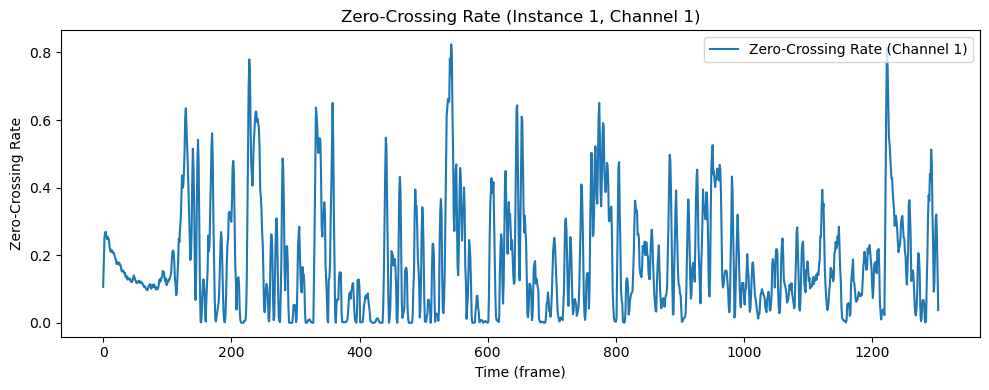

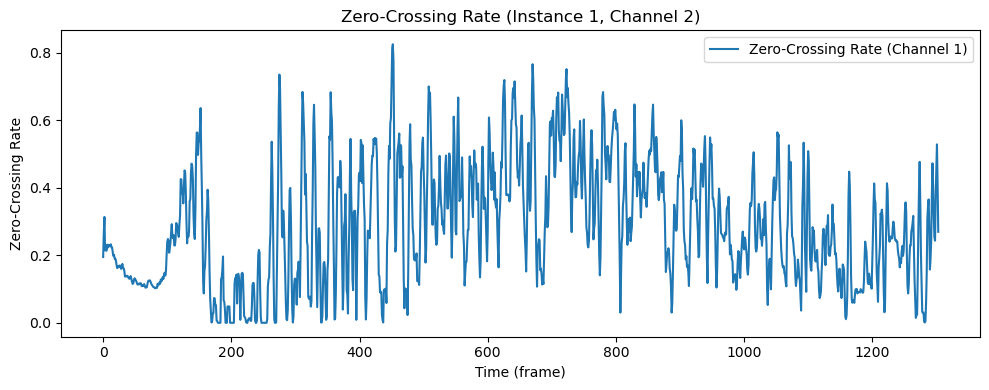

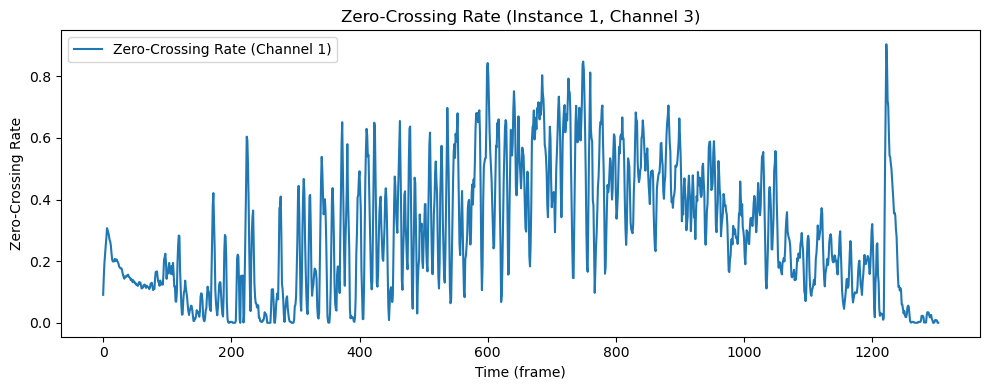

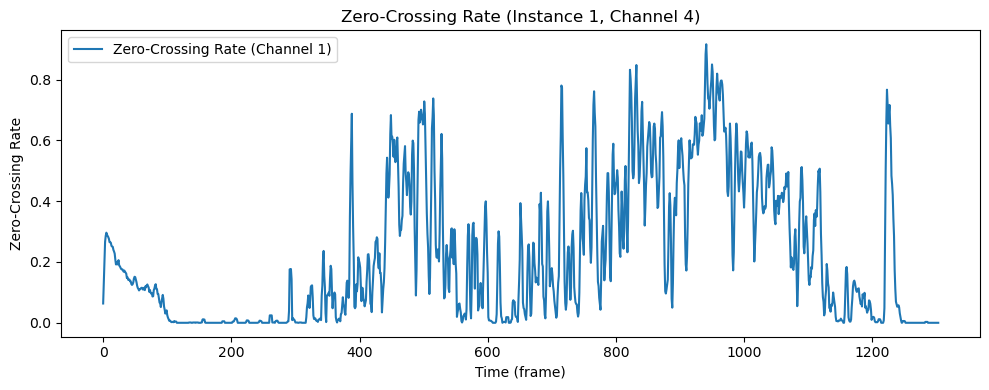

In [8]:
# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_zcr_h2.shape[0]):
    for channel_index in range(preprocessed_data_zcr_h2.shape[1]):
        zero_crossing_rate = preprocessed_data_zcr_h2[instance_index, channel_index] 
        MISC.plot_audio_features(instance_index=instance_index, chan_index=channel_index, zcr=zero_crossing_rate)
    break

## Dataset

In [9]:
dataset_h1 = CustomDataset(preprocessed_data_rms=preprocessed_data_rms_h1, coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_rms=preprocessed_data_rms_h2, coordinates=centroids_h2)

# Access a sample from the dataset
features_list, coordinates = dataset_h1[1]
print("Features List Length:", len(features_list))
print("Features Shape (Microphone 1):", features_list[0])
print("Features Shape (Microphone 2):", features_list[1])
print("Features Shape (Microphone 3):", features_list[2])
print("Features Shape (Microphone 4):", features_list[3])
print("Coordinates:", coordinates)

RMS:  (1000, 4)
RMS:  (104, 4)
Features List Length: 4
Features Shape (Microphone 1): 0.00052083656
Features Shape (Microphone 2): 0.0004996485
Features Shape (Microphone 3): 0.0007070924
Features Shape (Microphone 4): 0.00042909803
Coordinates: tensor([-3198.5410,  -744.5101])


## Random Forest Model Training

In [10]:
criterion = EUCLIDEAN_LOSS

In [11]:
rf_regressor = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring=MISC.custom_scoring) 
grid_search.fit(dataset_h1.preprocessed_data_rms, dataset_h1.coordinates)

print("Best Parameters:", grid_search.best_params_)
print("GridSearchCV Best Scoring:", -grid_search.best_score_)  # Negate for readability

Best Parameters: {'max_depth': 15, 'n_estimators': 500}
GridSearchCV Best Scoring: 1375.89115473422


In [12]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'])
rf_model.fit(dataset_h1.preprocessed_data_rms, dataset_h1.coordinates)

predicted_coordinates = rf_model.predict(dataset_h2.preprocessed_data_rms)

mse = mean_squared_error(centroids_h2, predicted_coordinates)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(centroids_h2, predicted_coordinates)
print("Mean Absolute Error:", mae)

# Calculate localization errors for each prediction
errors = []
for pred_coords, true_coords in zip(predicted_coordinates, dataset_h2.coordinates):
    error = criterion(torch.tensor(pred_coords), torch.tensor(true_coords))
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))
print("Score: ", rf_model.score(dataset_h2.preprocessed_data_rms, dataset_h2.coordinates))

Mean Squared Error: 1111374.4260948622
Mean Absolute Error: 801.3551807516183
Localization Error: 1252.98 (807.95)
Score:  0.12698091925025434


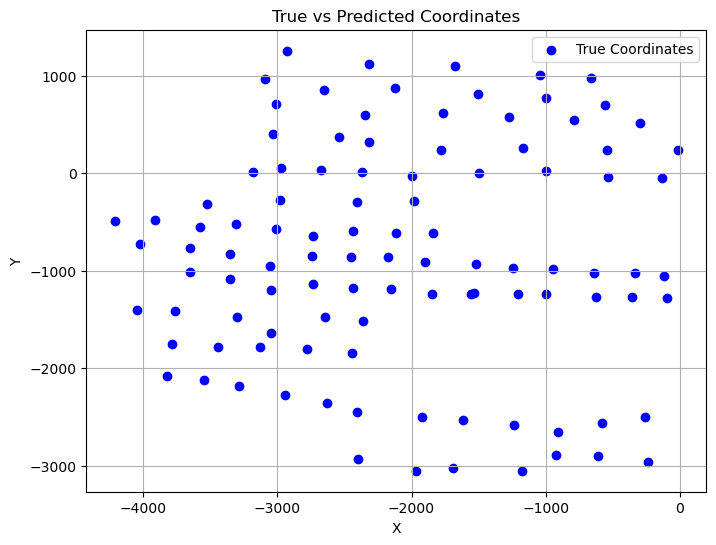

In [13]:
# Concatenate all true and predicted coordinates from all data points
all_true_coords = dataset_h2.coordinates.reshape(-1, 2)
all_pred_coords = predicted_coordinates.reshape(-1, 2)

# Plot all true and predicted coordinates on a single graph
plt.figure(figsize=(8, 6))
plt.scatter(all_true_coords[:, 0], all_true_coords[:, 1], color='blue', label='True Coordinates')
#plt.scatter(all_pred_coords[:, 0], all_pred_coords[:, 1], color='red', label='Predicted Coordinates')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()

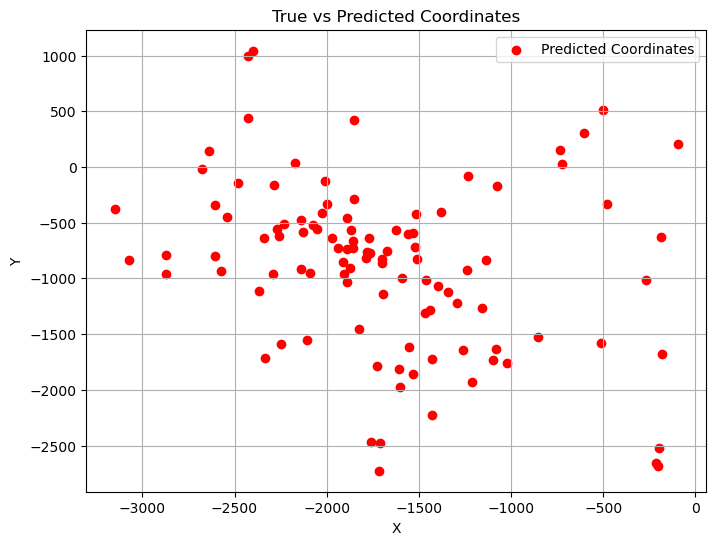

In [14]:
# Concatenate all true and predicted coordinates from all data points
all_true_coords = dataset_h2.coordinates.reshape(-1, 2)
all_pred_coords = predicted_coordinates.reshape(-1, 2)

# Plot all true and predicted coordinates on a single graph
plt.figure(figsize=(8, 6))
#plt.scatter(all_true_coords[:, 0], all_true_coords[:, 1], color='blue', label='True Coordinates')
plt.scatter(all_pred_coords[:, 0], all_pred_coords[:, 1], color='red', label='Predicted Coordinates')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()

## Zero-Crossing Rate

In [15]:
dataset_h1 = CustomDataset(preprocessed_data_zcr=preprocessed_data_zcr_h1, _type="zcr", coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_zcr=preprocessed_data_zcr_h2, _type="zcr", coordinates=centroids_h2)

zcr_features = np.sqrt(np.mean(dataset_h1.preprocessed_data_zcr**2, axis=-1))
X_train = zcr_features.reshape(1000, 4)
y_train = dataset_h1.coordinates
zcr_features = np.sqrt(np.mean(dataset_h2.preprocessed_data_zcr**2, axis=-1))
X_test = zcr_features.reshape(104, 4)
y_test = dataset_h2.coordinates

rf_regressor = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring=MISC.custom_scoring) 
grid_search.fit(X_train, y_train)

rf_model = RandomForestRegressor(random_state=42, n_estimators=500, max_depth=30)
rf_model.fit(X_train, y_train)

predicted_coords = rf_model.predict(X_test)

mse = mean_squared_error(y_test, predicted_coords)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, predicted_coords)
print("Mean Absolute Error:", mae)

# Calculate localization errors for each prediction
errors = []
for pred_coords, true_coords in zip(predicted_coords, y_test):
    error = criterion(torch.tensor(pred_coords), torch.tensor(true_coords))
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))
print("Score: ", rf_model.score(X_test, y_test))

ZCR:  (1000, 4, 1, 1304)
ZCR:  (104, 4, 1, 1304)
Mean Squared Error: 1443594.830295165
Mean Absolute Error: 988.824402489779
Localization Error: 1565.41 (660.82)
Score:  -0.13586839366244996
